In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from lib.Exercise1_1 import LQRSolver
from torch.utils.data import TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import os
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np

Proj_dtype = torch.double
Proj_device = 'cpu' 


In [14]:
class DGMhiddenlayerYYBver(nn.Module):

    # From the original paper of Justin's, presented by Yuebo Yang Apr.9th 2024
    
    def __init__(self, input_f, output_f, activation = 'tanh'):
        
        super(DGMhiddenlayerYYBver, self).__init__()

        self.input_f = input_f
        self.output_f = output_f

        # Params

        # Zl's

        self.Uzl = nn.Parameter(torch.Tensor(output_f, input_f))
        self.Wzl = nn.Parameter(torch.Tensor(output_f, output_f))
        self.bzl = nn.Parameter(torch.Tensor(output_f))

        # Gl's

        self.Ugl = nn.Parameter(torch.Tensor(output_f, input_f))
        self.Wgl = nn.Parameter(torch.Tensor(output_f, output_f))
        self.bgl = nn.Parameter(torch.Tensor(output_f))

        # Rl's

        self.Url = nn.Parameter(torch.Tensor(output_f, input_f))
        self.Wrl = nn.Parameter(torch.Tensor(output_f, output_f))
        self.brl = nn.Parameter(torch.Tensor(output_f))

        # Hl's

        self.Uhl = nn.Parameter(torch.Tensor(output_f, input_f))
        self.Whl = nn.Parameter(torch.Tensor(output_f, output_f))
        self.bhl = nn.Parameter(torch.Tensor(output_f))


        if activation == 'tanh':
            self.activation = torch.tanh
        else:
            self.activation = None 

        self.init_method = 'normal' # or 'uniform'

        self._initialize_params()

    def _initialize_params(self):

        if self.init_method == 'uniform':
            for param in self.parameters():
                if param.dim() > 1:
                    init.xavier_uniform_(param)  
                else:
                    init.constant_(param, 0) 
                    
        if self.init_method == 'normal':
            for param in self.parameters():
                if param.dim() > 1:
                    init.xavier_normal_(param)  
                else:
                    init.constant_(param, 0) 

    def forward(self, x, S1, Sl):

        Zl = self.activation(torch.mm(x, self.Uzl.t())+ torch.mm(Sl, self.Wzl.t()) + self.bzl)

        Gl = self.activation(torch.mm(x, self.Ugl.t())+ torch.mm(S1, self.Wgl.t()) + self.bgl)

        Rl = self.activation(torch.mm(x, self.Url.t())+ torch.mm(Sl, self.Wrl.t()) + self.brl)

        Hl = self.activation(torch.mm(x, self.Uhl.t())+ torch.mm(torch.mul(Sl,Rl), self.Whl.t()) + self.bhl)

        Sl_1 = torch.mul((1-Gl),Hl) + torch.mul(Zl,Sl)

        return Sl_1



In [15]:

class DGMNN_YYBver(nn.Module):

    # From the original paper of Justin's, presented by Yuebo Yang Apr.9th 2024

    def __init__(self, init_method = 'uniform'):
        super(DGMNN_YYBver, self).__init__()

        self.nodenum = 50

        self.layer1 = DGMhiddenlayerYYBver(3, self.nodenum)
        self.layer2 = DGMhiddenlayerYYBver(3, self.nodenum)
        self.layer3 = DGMhiddenlayerYYBver(3, self.nodenum)

        self.tanh = nn.Tanh()

        # Params

        # S1's

        self.W1 = nn.Parameter(torch.Tensor(self.nodenum, 3))
        self.b1 = nn.Parameter(torch.Tensor(self.nodenum))

        # Output's

        self.W = nn.Parameter(torch.Tensor(1, self.nodenum))
        self.b = nn.Parameter(torch.Tensor(1))

        self.activation = torch.tanh

        self.init_method = 'normal' # or 'uniform'

        self._initialize_params()

    def _initialize_params(self):

        if self.init_method == 'uniform':
            for param in self.parameters():
                if param.dim() > 1:
                    init.xavier_uniform_(param)  
                else:
                    init.constant_(param, 0) 
                    
        if self.init_method == 'normal':
            for param in self.parameters():
                if param.dim() > 1:
                    init.xavier_normal_(param)  
                else:
                    init.constant_(param, 0) 

        
    def forward(self, x):

        S_1 = self.activation(torch.mm(x, self.W1.t()) + self.b1)
        # l=1
        S_2 = self.layer1(x,S_1,S_1)
        # l=2
        S_3 = self.layer2(x,S_1,S_2)
        # l=3
        S_4 = self.layer3(x,S_1,S_3)

        output = torch.mm(S_4, self.W.t()) + self.b

        return output


In [16]:

class ControlNN_YYBver(nn.Module):

    # From the original paper of Justin's, presented by Yuebo Yang Apr.9th 2024

    def __init__(self, init_method = 'uniform'):
        super(ControlNN_YYBver, self).__init__()

        self.nodenum = 50

        self.layer1 = DGMhiddenlayerYYBver(3, self.nodenum)
        self.layer2 = DGMhiddenlayerYYBver(3, self.nodenum)
        self.layer3 = DGMhiddenlayerYYBver(3, self.nodenum)

        self.tanh = nn.Tanh()

        # Params

        # S1's

        self.W1 = nn.Parameter(torch.Tensor(self.nodenum, 3))
        self.b1 = nn.Parameter(torch.Tensor(self.nodenum))

        # Output's

        self.W = nn.Parameter(torch.Tensor(2, self.nodenum))
        self.b = nn.Parameter(torch.Tensor(2))

        self.activation = torch.tanh

        self.init_method = 'normal' # or 'uniform'

        self._initialize_params()

    def _initialize_params(self):

        if self.init_method == 'uniform':
            for param in self.parameters():
                if param.dim() > 1:
                    init.xavier_uniform_(param)  
                else:
                    init.constant_(param, 0) 
                    
        if self.init_method == 'normal':
            for param in self.parameters():
                if param.dim() > 1:
                    init.xavier_normal_(param)  
                else:
                    init.constant_(param, 0) 

        
    def forward(self, x):

        S_1 = self.activation(torch.mm(x, self.W1.t()) + self.b1)
        # l=1
        S_2 = self.layer1(x,S_1,S_1)
        # l=2
        S_3 = self.layer2(x,S_1,S_2)
        # l=3
        S_4 = self.layer3(x,S_1,S_3)

        output = torch.mm(S_4, self.W.t()) + self.b

        return output


In [17]:
def get_hessian(grad,x):
    Hessian = torch.tensor([], device = Proj_device)
    
    for i in range(len(x)):
        hessian = torch.tensor([], device = Proj_device)
        for j in range(len(grad[i])):
            u_xxi = torch.autograd.grad(grad[i][j], x, grad_outputs=torch.ones_like(grad[i][j]), retain_graph=True,create_graph=True, allow_unused=True)[0]           
            hessian = torch.cat((hessian, u_xxi[i].unsqueeze(0)))
        Hessian = torch.cat((Hessian, hessian.unsqueeze(0)),dim = 0)
        # print(Hessian)
    return Hessian

def get_hessian_(model,t,x):
    Hessian = torch.tensor([], device = Proj_device)
    for i in range(len(t)):
        x_i = V(x[i],requires_grad=True)
        input = torch.cat(((t[i]).unsqueeze(0), x_i),dim=0)
        u_in = model(input)
        grad = torch.autograd.grad(u_in, x_i, grad_outputs=torch.ones_like(u_in), create_graph=True, retain_graph=True)[0]
        hessian = torch.tensor([], device = Proj_device)
        for j in range(len(grad)):
            u_xxi = torch.autograd.grad(grad[j], x_i, grad_outputs=torch.ones_like(grad[j]), retain_graph=True,create_graph=True, allow_unused=True)[0]           
            hessian = torch.cat((hessian, u_xxi.unsqueeze(0)))
        Hessian = torch.cat((Hessian, hessian.unsqueeze(0)),dim = 0)
    return Hessian

def pde_residual(model, t, x, H, M, sigma, alpha, C, D):
    print(alpha)
    input = torch.cat((t.unsqueeze(1), x),dim=1)
    
    u = model(input)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    u_xx = get_hessian(u_x,x)

#    u_xx = get_hessian_(model,t,x)
    
    residual = u_t + 0.5 * torch.einsum('bii->b', sigma @ sigma.transpose(1,2) @ u_xx) + (u_x.unsqueeze(1) @ (H @ x.unsqueeze(1).transpose(1,2)) + u_x.unsqueeze(1) @ M @ alpha.unsqueeze(1).transpose(1,2) + x.unsqueeze(1) @ C @ x.unsqueeze(1).transpose(1,2) + alpha.unsqueeze(1) @ D @ alpha.unsqueeze(1).transpose(1,2)).squeeze()
    
    return residual

def boundary_condition(model, t, x, R, T):

    
    T_input = T * torch.ones_like(t)

    input = torch.cat((T_input.unsqueeze(1), x),dim=1)
    u = model(input)

    return u - (x.unsqueeze(1) @ R @ x.unsqueeze(1).transpose(1,2)).squeeze()

def total_residual(model, t, x, H, M, sigma, alpha, C, D, R, T):
    
    residual_loss = pde_residual(model, t, x, H, M, sigma, alpha, C, D).pow(2).mean()
    boundary_loss = boundary_condition(model, t, x, R, T).pow(2).mean()
    
    return residual_loss + boundary_loss


In [18]:
def new_data(T, num_samples):
    # num_samples = 1000
    t_samples = T * torch.rand(num_samples, dtype=Proj_dtype, device = Proj_device, requires_grad=False)
    x_ends = torch.tensor([-3,3], dtype = Proj_dtype)
    x_samples = x_ends[0] + (x_ends[1]- x_ends[0]) * torch.rand(num_samples , 2, dtype=Proj_dtype, device = Proj_device, requires_grad=False)
    return t_samples,x_samples

In [19]:
# Define matrices for LQR problem

H = torch.tensor([[1.2, 0.8], [-0.6, 0.9]], dtype=Proj_dtype, device = Proj_device)
M = torch.tensor([[0.5,0.7], [0.3,1.0]], dtype=Proj_dtype, device = Proj_device)
sigma = torch.tensor([[[0.08],[0.11]]], dtype=Proj_dtype, device = Proj_device)

C = torch.tensor([[1.6, 0.0], [0.0, 1.1]], dtype=Proj_dtype, device = Proj_device)
D = torch.tensor([[0.5, 0.0], [0.0, 0.7]], dtype=Proj_dtype, device = Proj_device)
R = torch.tensor([[0.9, 0.0], [0.0, 1.0]], dtype=Proj_dtype, device = Proj_device)
T = torch.tensor(1.0, dtype=Proj_dtype, device = Proj_device)

solver = LQRSolver(H, M, sigma, C, D, R, T=T, method="euler")


In [20]:
#Update of value function

def value_update(H, M, sigma, alpha_i, C, D, R, T, iter_p): 

    model_DGM = DGMNN_YYBver().double()
    optimizer_DGM = torch.optim.Adam(model_DGM.parameters(), lr=0.0001)
    scheduler_DGM = lr_scheduler.ExponentialLR(optimizer_DGM, gamma=0.9)


    #continue_training = input("Do you want to continue training or start a new one? (c/n): ").lower() == 'c'
    model_save_path = 'Exercise4/model_DGM_state_dict.pt'
    optimizer_save_path = 'Exercise4/optimizer_DGM_state.pt'
    
    if (iter_p > 0) and os.path.exists(model_save_path) and os.path.exists(optimizer_save_path):
        
        model_DGM.load_state_dict(torch.load(model_save_path))
        optimizer_DGM.load_state_dict(torch.load(optimizer_save_path))
        print("Continuing training from saved state.")
    else:
        print("Starting training from scratch.")

    epoch_losses = []

    iterations = 5
    epochs = 5

    patience = 10

    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    filename = f'Exercise4/value_training_loss_{timestamp}.dat'
    with open(filename, 'w') as f:

        for iteration in range(iterations):
            print(f'Iteration {iteration+1}/{iterations}'+'\n')
            
            t_data,x_data = new_data(T,5)
            dataset = TensorDataset(t_data,x_data)
            dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

            best_loss = float('inf')
            patience_counter = 0  

            for epoch in range(epochs):

                model_DGM.train()
                total_loss = 0
                
                for batch_idx, (_t_data,_x_data) in enumerate(dataloader):
                    optimizer_DGM.zero_grad()
                    t_data = _t_data.clone().requires_grad_(True)
                    x_data = _x_data.clone().requires_grad_(True)
                    if iter_p == 0:
                        alpha = alpha_i
                    else:
                        alpha = alpha_i(torch.cat((t_data.unsqueeze(1), x_data),dim=1)).squeeze()
                    loss = total_residual(model_DGM, t_data, x_data, H, M, sigma, alpha, C, D, R, T) 
                    loss.backward()
                    optimizer_DGM.step()
                    total_loss += loss.item()
                
                avg_loss = total_loss / len(dataloader)
                epoch_losses.append(avg_loss)
                
                scheduler_DGM.step()

                f.write(f'Iteration {iteration+1}, Epoch {epoch+1}, Loss: {avg_loss}\n')

                if avg_loss < best_loss:
                    best_loss = avg_loss
                    patience_counter = 0  
                    torch.save(model_DGM.state_dict(), model_save_path)
                    torch.save(optimizer_DGM.state_dict(), optimizer_save_path)
                else:
                    patience_counter += 1

                if epoch == 0 or (epoch+1) % 5 == 0:
                    print(f'Epoch {epoch+1}/{epochs} \t Loss: {avg_loss}')
                
                
                if patience_counter >= patience:
                    print(f'Early stopping triggered at epoch {epoch+1}')
                    break  
            print('\n')
    return model_DGM


In [21]:
#Hamiltonian

def Hamiltonian(model_control, model_value, t, x, H, M, C, D):
    
    input = torch.cat((t.unsqueeze(1), x),dim=1)

    u = model_value(input)
    a = model_control(input)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    H_i  = u_x.unsqueeze(1) @ H @ x.unsqueeze(1).transpose(1,2) + u_x.unsqueeze(1) @ M @ a.unsqueeze(1).transpose(1,2) + x.unsqueeze(1) @ C @ x.unsqueeze(1).transpose(1,2) + a.unsqueeze(1) @ D @ a.unsqueeze(1).transpose(1,2)

    #  The true hamiltonian
    H  = H_i.mean()
    return H

In [22]:
#Update of control

def control_update(H, M, C, D, T, model_value, iter_p): 

    control_DGM = ControlNN_YYBver().double()
    optimizer_control = torch.optim.Adam(control_DGM.parameters(), lr=0.0001)
    scheduler_control = lr_scheduler.ExponentialLR(optimizer_control, gamma=0.9)


    #continue_training = input("Do you want to continue training or start a new one? (c/n): ").lower() == 'c'

    model_save_path = 'Exercise4/control_DGM_state_dict.pt'
    optimizer_save_path = 'Exercise4/optimizer_control_state.pt'

    if (iter_p > 0) and os.path.exists(model_save_path) and os.path.exists(optimizer_save_path):
        
        control_DGM.load_state_dict(torch.load(model_save_path))
        optimizer_control.load_state_dict(torch.load(optimizer_save_path))
        print("Continuing training from saved state.")
    else:
        print("Starting training from scratch.")

    epoch_losses = []

    iterations = 5
    epochs = 5

    patience = 10

    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    filename = f'Exercise4/control_training_loss_{timestamp}.dat'

    with open(filename, 'w') as f:

        for iteration in range(iterations):
            print(f'Iteration {iteration+1}/{iterations}'+'\n')
            
            t_data,x_data = new_data(T,5)
            dataset = TensorDataset(t_data,x_data)
            dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

            best_loss = float('inf')
            patience_counter = 0  

            for epoch in range(epochs):

                control_DGM.train()
                total_loss = 0
                
                for batch_idx, (_t_data,_x_data) in enumerate(dataloader):
                    optimizer_control.zero_grad()
                    t_data = _t_data.clone().requires_grad_(True)
                    x_data = _x_data.clone().requires_grad_(True)
                    loss = Hamiltonian(control_DGM, model_value, t_data, x_data, H, M, C, D) 
                    loss.backward()
                    optimizer_control.step()
                    total_loss += loss.item()
                
                avg_loss = total_loss / len(dataloader)
                epoch_losses.append(avg_loss)
                
                scheduler_control.step()

                f.write(f'Iteration {iteration+1}, Epoch {epoch+1}, Loss: {avg_loss}\n')

                if avg_loss < best_loss:
                    best_loss = avg_loss
                    patience_counter = 0  
                    torch.save(control_DGM.state_dict(), model_save_path)
                    torch.save(optimizer_control.state_dict(), optimizer_save_path)
                else:
                    patience_counter += 1

                if epoch == 0 or (epoch+1) % 5 == 0:
                    print(f'Epoch {epoch+1}/{epochs} \t Loss: {avg_loss}')
                
                
                if patience_counter >= patience:
                    print(f'Early stopping triggered at epoch {epoch+1}')
                    break  
            print('\n')
        
    return control_DGM


In [23]:
# Define matrices for LQR problem

H = torch.tensor([[1.2, 0.8], [-0.6, 0.9]], dtype=Proj_dtype, device = Proj_device)
M = torch.tensor([[0.5,0.7], [0.3,1.0]], dtype=Proj_dtype, device = Proj_device)
sigma = torch.tensor([[[0.08],[0.11]]], dtype=Proj_dtype, device = Proj_device)

C = torch.tensor([[1.6, 0.0], [0.0, 1.1]], dtype=Proj_dtype, device = Proj_device)
D = torch.tensor([[0.5, 0.0], [0.0, 0.7]], dtype=Proj_dtype, device = Proj_device)
R = torch.tensor([[0.9, 0.0], [0.0, 1.0]], dtype=Proj_dtype, device = Proj_device)
T = torch.tensor(1.0, dtype=Proj_dtype, device = Proj_device)

solver = LQRSolver(H, M, sigma, C, D, R, T=T, method="euler")


In [24]:
# Policy Iteration

iter_p = 0
alpha = torch.tensor([[1., 1.]], dtype=Proj_dtype, device = Proj_device)

for iter_p in range(5):
    model_value = value_update(H, M, sigma, alpha, C, D, R, T, iter_p)
    alpha = control_update(H, M, C, D, T, model_value, iter_p)
    


Starting training from scratch.
Iteration 1/5

tensor([[1., 1.]], dtype=torch.float64)
Epoch 1/5 	 Loss: 147.00153800798483
tensor([[1., 1.]], dtype=torch.float64)
tensor([[1., 1.]], dtype=torch.float64)
tensor([[1., 1.]], dtype=torch.float64)
tensor([[1., 1.]], dtype=torch.float64)
Epoch 5/5 	 Loss: 133.36042333310002


Iteration 2/5

tensor([[1., 1.]], dtype=torch.float64)
Epoch 1/5 	 Loss: 229.04378961529727
tensor([[1., 1.]], dtype=torch.float64)
tensor([[1., 1.]], dtype=torch.float64)
tensor([[1., 1.]], dtype=torch.float64)
tensor([[1., 1.]], dtype=torch.float64)
Epoch 5/5 	 Loss: 223.10598895722694


Iteration 3/5

tensor([[1., 1.]], dtype=torch.float64)
Epoch 1/5 	 Loss: 55.78243727675599
tensor([[1., 1.]], dtype=torch.float64)
tensor([[1., 1.]], dtype=torch.float64)
tensor([[1., 1.]], dtype=torch.float64)
tensor([[1., 1.]], dtype=torch.float64)
Epoch 5/5 	 Loss: 55.04971179908525


Iteration 4/5

tensor([[1., 1.]], dtype=torch.float64)
Epoch 1/5 	 Loss: 94.8301460655936
tensor(

In [25]:
model_control = alpha
model_value.eval()
model_control.eval()


ControlNN_YYBver(
  (layer1): DGMhiddenlayerYYBver()
  (layer2): DGMhiddenlayerYYBver()
  (layer3): DGMhiddenlayerYYBver()
  (tanh): Tanh()
)

In [26]:
# Load interval settings for Monte Carlo simulations
load_interval_setting = torch.load('Exercise3_MC/value_numerical/3x3/'+'interval_setting.pt')
t_ends = load_interval_setting['t_ends']
t_num = load_interval_setting['t_num']
x_ends = load_interval_setting['x_ends']
x_num = load_interval_setting['x_num']

# Establish meshgrid structure for numerical solution
# This section generates a meshgrid for t and x, allowing us to compute the value function over a grid of time and state space
t_batch_i = torch.linspace(t_ends[0],t_ends[1],t_num,dtype=torch.double)  # Generate time points
t_batch = t_batch_i.repeat_interleave(x_num[0]*x_num[1])  # Repeat each time point for all combinations of state space

x1 = torch.linspace(x_ends[0][0],x_ends[0][1],x_num[0],dtype=torch.double)  # Generate points for the first dimension of state space
x2 = torch.linspace(x_ends[1][0],x_ends[1][1],x_num[1],dtype=torch.double)  # Generate points for the second dimension of state space

x_batch = torch.cartesian_prod(x1, x2).unsqueeze(1).repeat(t_num, 1, 1)  # Generate all combinations of state space points for each time point

x_batch_i = torch.cartesian_prod(x1, x2).unsqueeze(1)  # Generate all combinations of state space points

X1 = x_batch_i[:, 0, 0].view(x_num[0], x_num[1])  # Reshape for plotting
X2 = x_batch_i[:, 0, 1].view(x_num[0], x_num[1])  # Reshape for plotting


In [33]:
value_ns = solver.value_function(t_batch, x_batch)
value_nn = model_value(torch.cat((t_batch.unsqueeze(1), x_batch.squeeze(1)),dim=1)).squeeze()
control_ns = solver.markov_control(t_batch, x_batch).squeeze(1)
control_nn = model_control(torch.cat((t_batch.unsqueeze(1), x_batch.squeeze(1)),dim=1)).squeeze()

In [36]:
print(control_ns)

tensor([[  6.4607,   9.9608],
        [ 17.4128,  16.2514],
        [ 28.3648,  22.5420],
        [-10.9521,  -6.2906],
        [  0.0000,   0.0000],
        [ 10.9521,   6.2906],
        [-28.3648, -22.5420],
        [-17.4128, -16.2514],
        [ -6.4607,  -9.9608],
        [  6.1245,   9.6466],
        [ 14.7496,  13.9140],
        [ 23.3748,  18.1813],
        [ -8.6251,  -4.2673],
        [  0.0000,   0.0000],
        [  8.6251,   4.2673],
        [-23.3748, -18.1813],
        [-14.7496, -13.9140],
        [ -6.1245,  -9.6466],
        [  5.8518,   9.3778],
        [ 12.3966,  11.8380],
        [ 18.9414,  14.2982],
        [ -6.5448,  -2.4602],
        [  0.0000,   0.0000],
        [  6.5448,   2.4602],
        [-18.9414, -14.2982],
        [-12.3966, -11.8380],
        [ -5.8518,  -9.3778],
        [  5.6369,   9.1451],
        [ 10.3496,  10.0174],
        [ 15.0623,  10.8897],
        [ -4.7127,  -0.8723],
        [  0.0000,   0.0000],
        [  4.7127,   0.8723],
        [-

In [35]:
print(control_nn)

tensor([[-0.1477,  1.0181],
        [ 0.1116,  0.5276],
        [-1.3454, -0.6120],
        [-0.7120, -0.6084],
        [-0.0082, -0.0151],
        [-1.5489, -1.2347],
        [ 0.2598,  0.5133],
        [ 0.3144, -0.6115],
        [-0.3197, -1.1905],
        [-0.1297,  0.9703],
        [ 0.0752,  0.5057],
        [-1.3316, -0.7493],
        [-0.6545, -0.6657],
        [-0.0185, -0.0334],
        [-1.5471, -1.2833],
        [ 0.3455,  0.4928],
        [ 0.2589, -0.5773],
        [-0.3015, -1.1657],
        [-0.1047,  0.9271],
        [ 0.0477,  0.4819],
        [-1.3197, -0.8726],
        [-0.5953, -0.7154],
        [-0.0301, -0.0479],
        [-1.5462, -1.3246],
        [ 0.4250,  0.4729],
        [ 0.2045, -0.5354],
        [-0.2906, -1.1399],
        [-0.0750,  0.8890],
        [ 0.0293,  0.4573],
        [-1.3097, -0.9778],
        [-0.5344, -0.7575],
        [-0.0433, -0.0584],
        [-1.5453, -1.3557],
        [ 0.4973,  0.4534],
        [ 0.1508, -0.4846],
        [-0.2887, -1

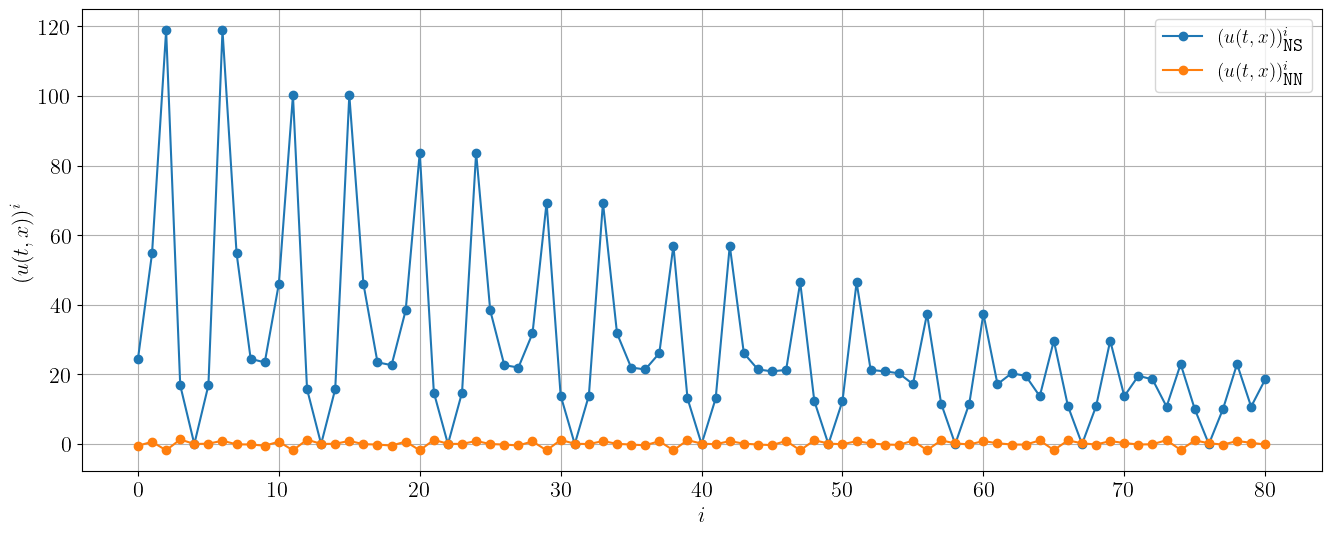

In [32]:
# Plotting the comparison between J (from MC simulations) and model predictions

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

plt.figure(figsize=(16, 6))
plt.plot(value_ns.numpy(), marker='o', label = r'\rmfamily \textmd {$(u(t,x))^{i}_{\texttt{NS}}$}')  # Plotting J values obtained from Monte Carlo simulations
plt.plot(value_nn.detach().numpy(), marker='o', label = r'\rmfamily \textmd {$(u(t,x))^{i}_{\texttt{NN}}$}')  # Plotting the model's output for comparison

#plt.yscale('log')  # Use a logarithmic scale for the y-axis to better visualize differences across magnitudes
plt.xlabel(r'\rmfamily \textmd {$i$}', fontsize=16)  # The x-axis represents the index or position of each data point
plt.ylabel(r'\rmfamily \textmd {$(u(t,x))^i$}', fontsize=16)  # The y-axis represents the value function or control action predicted by the model
#plt.title('Comparison of J from MC Simulations and Model DGM Output')  # Title of the plot
plt.legend(fontsize=14)  # Include a legend to distinguish between the curves
plt.grid(True)  # Enable grid for better readability
plt.rcParams['axes.labelsize'] = 16 
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.savefig('Exercise3/ComparisonNN2MC.pdf', format='pdf', dpi=600)
plt.savefig('Exercise3/ComparisonNN2MC.png', format='png', dpi=600)

plt.show()  # Display the plot
